# 一、目标检测和数据集

In [2]:
import matplotlib.pyplot as plt
import torch
from d2l import torch as d2l

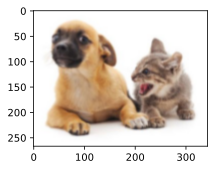

In [3]:
d2l.set_figsize()
img = d2l.plt.imread('images/catdog.jpg')
d2l.plt.imshow(img)

## 在目标检测中，我们通常使用边界框（bounding box）来描述对象的空间位置。 边界框是矩形的，由矩形左上角的以及右下角的x和y坐标决定。 另一种常用的边界框表示方法是边界框中心的轴坐标以及框的宽度和高度。

## 在这里，我们定义在这两种表示法之间进行转换的函数：box_corner_to_center从两角表示法转换为中心宽度表示法，而box_center_to_corner反之亦然。 输入参数boxes可以是长度为4的张量，也可以是形状为（n，4）的二维张量，其中n是边界框的数量。

In [4]:
def box_corner_to_center(boxes):
    # x1, y1, x2, y2分别对应左上和右下的坐标
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    return torch.stack((cx, cy, w, h), axis=-1)

def box_center_to_corner(boxes):
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - w * 0.5
    x2 = cx + w * 0.5
    y1 = cy - h * 0.5
    y2 = cy + h * 0.5
    return torch.stack((x1, y1, x2, y2), axis=-1)

In [5]:
dog_bbox, cat_bbox = [20.0, 20.0, 230.0, 250.0], [190.0, 50.0, 330.0, 240.0]
boxes = torch.tensor((dog_bbox, cat_bbox))
print(boxes)
# 可以看到我们的两个转换函数是正确的
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[ 20.,  20., 230., 250.],
        [190.,  50., 330., 240.]])


tensor([[True, True, True, True],
        [True, True, True, True]])

## 我们可以将边界框在图中画出，以检查其是否准确。 画之前，我们定义一个辅助函数bbox_to_rect。 它将边界框表示成matplotlib的边界框格式。

In [6]:
def bbox_to_rect(bbox, color):
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2
    )

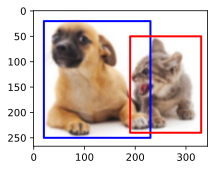

In [7]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'))

## 目标检测数据集

## 目标检测领域没有像MNIST和Fashion-MNIST那样的小数据集。 为了快速测试目标检测模型，我们收集并标记了一个小型数据集。 首先，我们拍摄了一组香蕉的照片，并生成了1000张不同角度和大小的香蕉图像。 然后，我们在一些背景图片的随机位置上放一张香蕉的图像。 最后，我们在图片上为这些香蕉标记了边界框。

In [8]:
import os
import pandas as pd
import torchvision

In [9]:
import hashlib
import requests
import zipfile
import tarfile

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'


# Defined in file: ./chapter_multilayer-perceptrons/kaggle-house-price.md
def download(name, cache_dir=os.path.join('.', 'data2')):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name):
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return data_dir

DATA_HUB['banana-detection'] = (
    DATA_URL + 'banana-detection.zip', '5de26c8fce5ccdea9f91267273464dc968d20d72')
data_dir = download_extract('banana-detection')
print(data_dir)

.\data2\banana-detection


## set_index('img_name')将DataFrame的索引设置为名为 'img_name' 的列。这可以方便地使用图像名称来检索和操作数据，因为现在图像名称成为了索引，而不再是默认的整数索引。例如，如果你有一个名为'image123.jpg'的图像，你可以使用csv_data.loc['image123.jpg']来检索与该图像相关的整行数据。这种操作通常在数据处理中很有用，特别是当数据中的某一列可以充当唯一标识符或关键字时。

In [10]:
def read_data_bananas(is_train=True):
    data_dir = download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    '''
    这行代码使用了一个for循环迭代csv_data这个DataFrame的每一行。在每次迭代中，img_name和target分别是该行中 "img_name" 列和其余列的值。具体来说，img_name将是该行中 "img_name" 列的值，而target将是去除 "img_name" 列后的其他列的值（即该行的目标数据）。
    '''
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'images', f'{img_name}')))
        # 这里的target包含（类别，左上角x，左上角y，右下角x，右下角y），
        # 其中所有图像都具有相同的香蕉类（索引为0）
        targets.append(list(target))
    '''
    这行代码涉及PyTorch库中的torch.tensor操作，它用于创建一个PyTorch张量。具体而言，torch.tensor(targets)将一个名为targets的变量或数组转换为PyTorch张量。
    接着，.unsqueeze(1)是一个张量的操作，它在指定的维度上增加一个大小为1的维度。在这里，1是表示要在维度1上插入一个大小为1的维度。这通常用于在处理数据时改变张量的形状。
    最后，/ 256是一个除法操作，它将张量中的每个元素都除以256。这种操作可能是为了将目标数据进行归一化，将其范围缩放到0到1之间。这在训练神经网络时很常见，因为归一化可以有助于提高模型的训练稳定性和收敛速度。通常，图像数据的像素值在0到255之间，所以除以256可以将其归一化到0到1之间。
    '''
    return images, torch.tensor(targets).unsqueeze(1) / 256

In [11]:
# features和labels都是列表，features当中是一系列图像（3个通道，高宽为256x256），labels当中是一系列二维标签（为什么是二维？因为unsqueeze操作给他增加了一个维度），由于是列表，所以我们不可以输出features和labels的.shape操作，但我们可以看当中的每一个元素的shape
features, labels = read_data_bananas()
features[0].shape, labels[0].shape

(torch.Size([3, 256, 256]), torch.Size([1, 5]))

In [12]:
class BananaDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(features)) + (f' training examples' if is_train else f' valid examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

In [13]:
# 最后，我们定义load_data_bananas函数，来为训练集和测试集返回两个数据加载器实例。对于测试集，无须按随机顺序读取它。
def load_data_bananas(batch_size):
    train_iter = torch.utils.data.DataLoader(BananaDataset(True), batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananaDataset(False), batch_size)
    return train_iter, val_iter

In [14]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
# batch是一个包含feature和label的列表，想要调用下一个batch，得重新写一下代码
batch[0].shape, batch[1].shape

read 1000 training examples
read 1000 valid examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

## .permute(0, 2, 3, 1)：这是一个张量的维度变换操作。在这里，维度的顺序被改变，从 (batch_size, channels, height, width) 变为 (batch_size, height, width, channels)。这通常是因为在图像处理中，最后一个维度通常表示通道（例如，RGB通道）。

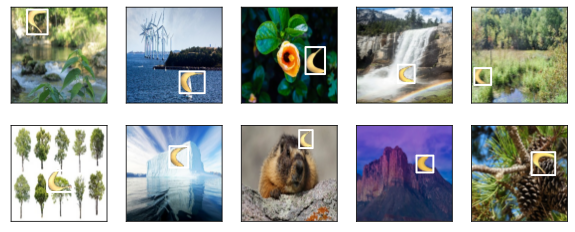

In [15]:
# 取出第一个batch当中的前十条数据
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    # 为什么要乘以一个edge_size呢？因为之前做的操作给每一个图像的目标检测位置值都除以了一个256的值进行归一化，现在需要用到原始的位置，所以需要乘回来
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

# 二、锚框

In [16]:
import torch
from d2l import torch as d2l

In [17]:
def multibox_prior(data, sizes, ratios):
    # data是一个batch_size x channel x h x w的矩阵，所以通过data.shape[2:]得到高宽
    # 注意！！！不是data[-2:]而是data.shape[2:]
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    # 经过计算发现，对每个像素点，生成num_sizes + num_ratios - 1个锚框就足够了
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)

    # 为了将锚点移动到像素的中心，需要设置偏移量
    offset_h, offset_w = 0.5, 0.5
    steps_h, steps_w = 1.0 / in_height, 1.0 / in_width

    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]), sizes[0] * torch.sqrt(ratio_tensor[1:]))) * in_height / in_width
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]), sizes[0] / torch.sqrt(ratio_tensor[1:])))

    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(in_width * in_height, 1) / 2
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y], dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = anchor_manipulations + out_grid
    # output维度为((num_sizes + num_ratios - 1) * in_height * in_width, 4)
    return output.unsqueeze(0)

In [18]:
img = d2l.plt.imread('images/catdog.jpg')
h, w = img.shape[:2]
print(h, w)

267 343


In [19]:
X = torch.rand(size=(1, 3, 561, 728))
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

torch.Size([1, 2042040, 4])

## 将锚框变量Y的形状更改为(图像高度,图像宽度,以同一像素为中心的锚框的数量,4)后，我们可以获得以指定像素的位置为中心的所有锚框。 在接下来的内容中，我们访问以（250,250）为中心的第一个锚框。 它有四个元素：锚框左上角的(x, y)轴坐标和右下角的(x, y)轴坐标。 输出中两个轴的坐标各分别除以了图像的宽度和高度。

In [20]:
# 精简输出精度
torch.set_printoptions(2)

In [21]:
h = 561
w = 728
boxes = Y.reshape(h, w, 5, 4)
boxes[250, 250, 0, :]

tensor([0.06, 0.07, 0.63, 0.82])

In [22]:
# 为了显示以图像中以某个像素为中心的所有锚框，定义下面的show_bboxes函数来在图像上绘制多个边界框
def show_bboxes(axes, bboxes, labels=None, colors=None):
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i], va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

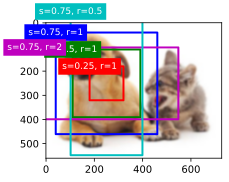

In [23]:
import torchvision
img = d2l.Image.open('images/catdog.jpg')
aug = torchvision.transforms.Resize((h, w))
img = aug(img)
d2l.set_figsize()
bbox_scale = torch.tensor((w, h, w, h))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale, ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
             's=0.75, r=0.5'])

# 给定两个锚框或边界框的列表，以下box_iou函数将在这两个列表中计算它们成对的交并比。
# 下面的函数的详细注释见[test1.py](test1.py)

In [24]:
def box_iou(boxes1, boxes2):
    box_area = lambda box: (box[:, 2] - box[:, 0]) * (box[:, 3] - box[:, 1])
    area1 = box_area(boxes1)
    area2 = box_area(boxes2)

    inter_upperleft = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_bottemright = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])

    inters = (inter_bottemright - inter_upperleft).clamp(min=0)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]

    union_areas = area1[:, None] + area2 - inter_areas
    return inter_areas / union_areas

In [25]:
# 将真实边界框分配给锚框
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    jaccard = box_iou(anchors, ground_truth)
    anchors_bbox_map = torch.full((num_anchors, ), -1, dtype=torch.long, device=device)
    max_ious, indices = torch.max(jaccard, dim=1)

    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
    box_j = indices[max_ious >= iou_threshold]

    anchors_bbox_map[anc_i] = box_j

    col_discard = torch.full((num_anchors, ), -1)
    row_discard = torch.full((num_gt_boxes, ), -1)

    for _ in range(num_gt_boxes):
        max_id = torch.argmax(jaccard)
        box_id = (max_id % num_gt_boxes).long()
        anc_id = (max_id / num_gt_boxes).long()
        anchors_bbox_map[anc_id] = box_id
        jaccard[:, box_id] = col_discard
        jaccard[anc_id, :] = row_discard
    return anchors_bbox_map

In [26]:
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """对锚框偏移量的转换"""
    c_anc = d2l.box_corner_to_center(anchors)
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

### 如果一个锚框没有被分配真实边界框，我们只需将锚框的类别标记为背景（background）。 背景类别的锚框通常被称为负类锚框，其余的被称为正类锚框。 我们使用真实边界框（labels参数）实现以下multibox_target函数，来标记锚框的类别和偏移量（anchors参数）。 此函数将背景类别的索引设置为零，然后将新类别的整数索引递增一。

### 注意：我们只对被分配了标签的锚框计算其与ground truth锚框之间的偏移

In [27]:
def multibox_target(anchors, labels):
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(label[:, 1:], anchors, device)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(1, 4)
        class_labels = torch.zeros(num_anchors, dtype=torch.long, device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32, device=device)

        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]

        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]

        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

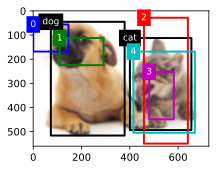

In [28]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4'])

In [29]:
labels = multibox_target(anchors.unsqueeze(dim=0), ground_truth.unsqueeze(dim=0))

In [30]:
# 每个锚框对应的类别标签，0表示背景，1表示狗，2表示猫
labels[2]

tensor([[0, 1, 2, 0, 2]])

In [31]:
# 返回的第二个元素是掩码（mask）变量，形状为（批量大小，锚框数的四倍）。 掩码变量中的元素与每个锚框的4个偏移量一一对应。 由于我们不关心对背景的检测，负类的偏移量不应影响目标函数。 通过元素乘法，掩码变量中的零将在计算目标函数之前过滤掉负类偏移量。
labels[1]

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1.]])

In [32]:
# 返回的第一个元素包含了为每个锚框标记的四个偏移值。 请注意，负类锚框的偏移量被标记为零。
labels[0]

tensor([[-0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00,  1.40e+00,  1.00e+01,
          2.59e+00,  7.18e+00, -1.20e+00,  2.69e-01,  1.68e+00, -1.57e+00,
         -0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00, -5.71e-01, -1.00e+00,
          4.17e-06,  6.26e-01]])

In [33]:
# 该函数将锚框和偏移量预测作为输入，并应用逆偏移变换来返回预测的边界框坐标（即之前根据锚框和ground truth边界框计算偏移量相反的步骤）
def offset_inverse(anchors, offset_preds):
    anc = d2l.box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = d2l.box_center_to_corner(pred_bbox)
    return predicted_bbox

In [34]:
def nms(boxes, scores, iou_threshold):
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1: break
        iou = box_iou(boxes[i, :].reshape(-1, 4), boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

In [39]:
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5, pos_threshold=0.00999999):
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)

        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]

        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]

        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

In [40]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                      [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([[0] * 4,  # 背景的预测概率
                      [0.9, 0.8, 0.7, 0.1],  # 狗的预测概率
                      [0.1, 0.2, 0.3, 0.9]])  # 猫的预测概率

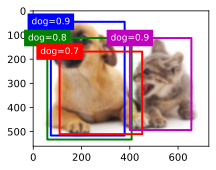

In [41]:
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale, ['dog=0.9', 'dog=0.8', 'dog=0.7', 'dog=0.9'])

In [42]:
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0),
                            nms_threshold=0.5)
output

tensor([[[ 0.00,  0.90,  0.10,  0.08,  0.52,  0.92],
         [ 1.00,  0.90,  0.55,  0.20,  0.90,  0.88],
         [-1.00,  0.80,  0.08,  0.20,  0.56,  0.95],
         [-1.00,  0.70,  0.15,  0.30,  0.62,  0.91]]])

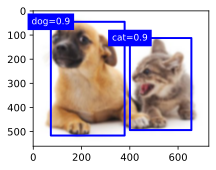

In [43]:
# 删除-1类别（背景）的预测边界框后，我们可以输出由非极大值抑制保存的最终预测边界框。
fig = d2l.plt.imshow(img)
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)